# K Means Clustering – Life Expectancy Data

## Project Description:
This project applies K-Means clustering to explore global patterns in life expectancy across countries. Using life expectancy data for males and females, the analysis seeks to uncover geographic and demographic trends that may correspond to regional health outcomes and socioeconomic development. The project involves data cleaning, outlier removal, feature transformation, geocoding of country coordinates, and visualization of clustering results on a world map. By combining geospatial and demographic dimensions, the notebook demonstrates how unsupervised learning can reveal meaningful structures in real-world public health data.

### Objectives:
* Data preparation: Import, inspect, and clean the dataset to ensure consistent column names and remove any outliers that could distort clustering results. Create categorical bins for life expectancy and geocode each country to obtain latitude and longitude for spatial clustering. Visualize relationships between male and female life expectancy and identify high- and low-expectancy regions.
* Model development: Implement the K-Means clustering algorithm to group countries based on geographic location and life expectancy characteristics.
* Model evaluation: Use silhouette scores to assess the quality of clusters and determine the optimal number of clusters (k).
* Visualization of Results, Insights, Interpretation: Plot country clusters on a coordinate map and compare cluster characteristics to identify regional trends. Interpret clusters in relation to global health disparities, highlighting countries or regions with similar life expectancy profiles.


### Public dataset source:
[Kaggle Data Set](https://www.kaggle.com/datasets/ignacioazua/life-expectancy)
The dataset from Worldometer provides a ranked list of countries based on life expectancy at birth, which represents the average number of years a newborn is expected to live under current mortality rates. It includes global, regional, and country-specific life expectancy figures, with separate data for males and females.

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, silhouette_score
from sklearn.impute import SimpleImputer

## Data Exploration and Manipulation

In [2]:
# Establish file path and import data
path = 'life_expectancy.csv'
df = pd.read_csv(path)
df.head(10)

,Country,Sum of Females Life Expectancy,Sum of Life Expectancy (both sexes),Sum of Males Life Expectancy
0,Chad,57.19,55.24,53.36
1,Nigeria,54.94,54.64,54.33
2,South Sudan,60.75,57.74,54.76
3,Lesotho,60.44,57.80,55.03
4,Central African Republic,59.56,57.67,55.51
5,Somalia,61.55,58.97,56.49
6,Burkina Faso,63.43,61.29,59.11
7,Mali,62.15,60.68,59.25
8,Benin,62.42,60.96,59.52
9,Guinea,62.09,60.90,59.66


In [45]:
df.describe()

,female_LE,both_LE,male_LE
count,200.000000,200.000000,200.000000
mean,76.776900,74.133700,71.517200
std,8.820332,8.571318,8.419633
min,54.940000,54.640000,53.360000
25%,71.300000,68.732500,66.270000
50%,77.955000,74.700000,71.250000
75%,81.985000,79.062500,76.565000
max,149.220000,143.280000,137.640000


In [38]:
for c in df.columns:
    print(repr(c))  # shows hidden chars like '\xa0' or trailing spaces

'Country'
'Sum of Females  Life Expectancy'
'Sum of Life Expectancy  (both sexes)'
'Sum of Males  Life Expectancy'


In [3]:
# See current columns (so you can rewrite them)
print(list(df.columns))

# Provide your custom names in the exact same order
new_names = [
    "country",
    "female_LE",
    "both_LE",
    "male_LE",
]

# Assign
if len(new_names) != len(df.columns):
    raise ValueError("new_names length must match number of columns")
df.columns = new_names
df.columns

['Country', 'Sum of Females  Life Expectancy', 'Sum of Life Expectancy  (both sexes)', 'Sum of Males  Life Expectancy']


Index(['country', 'female_LE', 'both_LE', 'male_LE'], dtype='object')

In [4]:
# The one value for Micronesia life expectancy for males and females seems to be an outlier
# Filter out outliers
mask = (df['female_LE'] >= 100) & (df['male_LE'] >= 100)
df_filter = df.loc[~mask].copy()

print("Original DataFrame:")
print(df)
print("\nDataFrame after removing outliers using IQR method:")
print(df_filter)

Original DataFrame:
                      country  female_LE  both_LE  male_LE
0                        Chad      57.19    55.24    53.36
1                     Nigeria      54.94    54.64    54.33
2                 South Sudan      60.75    57.74    54.76
3                     Lesotho      60.44    57.80    55.03
4    Central African Republic      59.56    57.67    55.51
..                        ...        ...      ...      ...
195               Switzerland      85.95    84.09    82.17
196      United Arab Emirates      84.32    83.07    82.17
197                 Australia      85.85    84.07    82.28
198                 Hong Kong      88.26    85.63    82.97
199                Micronesia     149.22   143.28   137.64

[200 rows x 4 columns]

DataFrame after removing outliers using IQR method:
                      country  female_LE  both_LE  male_LE
0                        Chad      57.19    55.24    53.36
1                     Nigeria      54.94    54.64    54.33
2                 

In [55]:
df_filter.describe()

,female_LE,both_LE,male_LE
count,199.000000,199.000000,199.000000
mean,76.412864,73.786231,71.184925
std,7.180037,7.040573,7.003951
min,54.940000,54.640000,53.360000
25%,71.280000,68.725000,66.270000
50%,77.910000,74.690000,71.080000
75%,81.900000,78.950000,76.230000
max,88.260000,85.630000,82.970000


/var/folders/cx/jsmdsr392b16bs81k3s1s4n00000gn/T/ipykernel_58202/2893806423.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


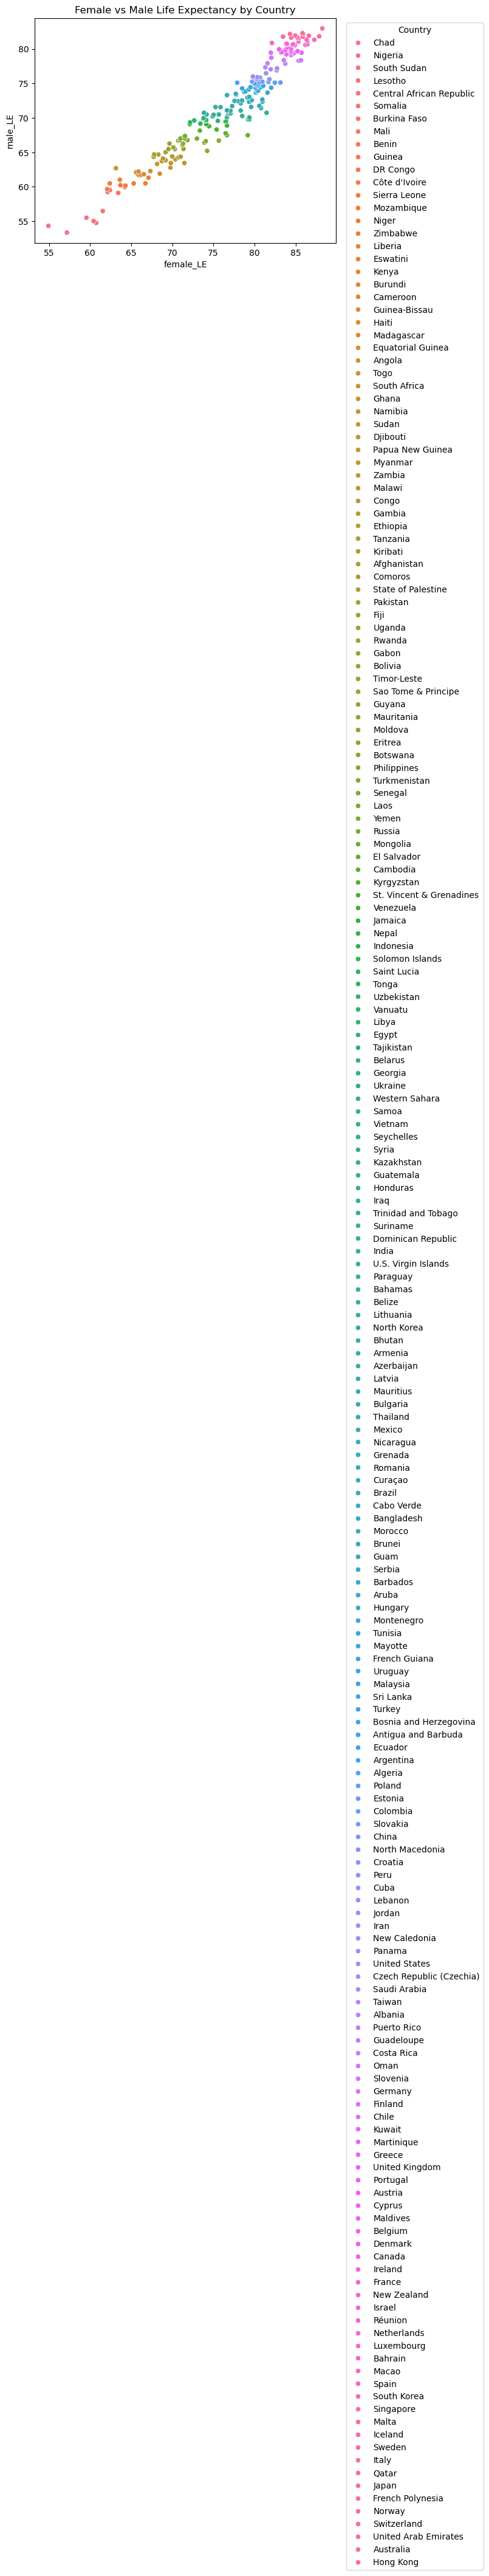

In [56]:
sns.scatterplot(
    data=df_filter,
    x='female_LE',
    y='male_LE',
    hue="country"
)
plt.title("Female vs Male Life Expectancy by Country")
plt.legend(title="Country", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

In [5]:
# Create bins for life expectancy values so that they are categorical
# Define custom bins and labels
bins = [50,60,70,80,90]
labels = ['50-60', '60-70', '70-80', '80-90']

# Create a new categorical column
df_filter['life_expectancy_male'] = pd.cut(df_filter['male_LE'], bins=bins, labels=labels, right=True)
df_filter['life_expectancy_female'] = pd.cut(df_filter['female_LE'], bins=bins, labels=labels, right=True)

print(df_filter)

                      country  female_LE  both_LE  male_LE  \
0                        Chad      57.19    55.24    53.36   
1                     Nigeria      54.94    54.64    54.33   
2                 South Sudan      60.75    57.74    54.76   
3                     Lesotho      60.44    57.80    55.03   
4    Central African Republic      59.56    57.67    55.51   
..                        ...        ...      ...      ...   
194                    Norway      84.97    83.46    81.94   
195               Switzerland      85.95    84.09    82.17   
196      United Arab Emirates      84.32    83.07    82.17   
197                 Australia      85.85    84.07    82.28   
198                 Hong Kong      88.26    85.63    82.97   

    life_expectancy_male life_expectancy_female  
0                  50-60                  50-60  
1                  50-60                  50-60  
2                  50-60                  60-70  
3                  50-60                  60-70  
4    

In [10]:
countries = df_filter['country'].unique().tolist()
len(countries)

199

In [78]:
countries

['Chad',
 'Nigeria',
 'South Sudan',
 'Lesotho',
 'Central African Republic',
 'Somalia',
 'Burkina Faso',
 'Mali',
 'Benin',
 'Guinea',
 'DR Congo',
 "Côte d'Ivoire",
 'Sierra Leone',
 'Mozambique',
 'Niger',
 'Zimbabwe',
 'Liberia',
 'Eswatini',
 'Kenya',
 'Burundi',
 'Cameroon',
 'Guinea-Bissau',
 'Haiti',
 'Madagascar',
 'Equatorial Guinea',
 'Angola',
 'Togo',
 'South Africa',
 'Ghana',
 'Namibia',
 'Sudan',
 'Djibouti',
 'Papua New Guinea',
 'Myanmar',
 'Zambia',
 'Malawi',
 'Congo',
 'Gambia',
 'Ethiopia',
 'Tanzania',
 'Kiribati',
 'Afghanistan',
 'Comoros',
 'State of Palestine',
 'Pakistan',
 'Fiji',
 'Uganda',
 'Rwanda',
 'Gabon',
 'Bolivia',
 'Timor-Leste',
 'Sao Tome & Principe',
 'Guyana',
 'Mauritania',
 'Moldova',
 'Eritrea',
 'Botswana',
 'Philippines',
 'Turkmenistan',
 'Senegal',
 'Laos',
 'Yemen',
 'Russia',
 'Mongolia',
 'El Salvador',
 'Cambodia',
 'Kyrgyzstan',
 'St. Vincent & Grenadines',
 'Venezuela',
 'Jamaica',
 'Nepal',
 'Indonesia',
 'Solomon Islands',
 'Sa

In [6]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="empower_lab")

def get_country_coordinates(country_name):
        try:
            location = geolocator.geocode(country_name, timeout=10) # Set a timeout for the request
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except GeocoderTimedOut:
            print(f"Geocoding timed out for: {country_name}. Retrying...")
            return get_country_coordinates(country_name) # Retry on timeout
        except Exception as e:
            print(f"Error geocoding {country_name}: {e}")
            return None, None

In [7]:
df0 = df_filter.copy()

In [11]:
def chunk_and_geocode(countries, get_country_coordinates, chunk_size=50): # geopy geocoder times out with over 100 entries, so divide up into chunks
    
    dfs = []

    for i in range(0, len(countries), chunk_size): # from 0 to len(countries) in 50 chunk increments 
        chunk = countries[i:i + chunk_size] # establish which chunk of countries to pull from
        df0 = pd.DataFrame({'country': chunk}) # create a dataframe with that chunk
        df0[['Latitude', 'Longitude']] = df0['country'].apply( # find long and lat for chunk and add to corresponding columns
            lambda x: pd.Series(get_country_coordinates(x))
        )
        dfs.append(df0) # appends each df chunk
    return dfs

dfs = chunk_and_geocode(countries, get_country_coordinates)

In [13]:
# Combine dfs
all_countries_df = pd.concat(dfs, axis=0)

In [14]:
# Match countries from new combined countries DF to the original df_filter
# Merge on the 'country' column
merged_df = df0.merge(all_countries_df, on='country', how='left') # keep all rows from all_countries

In [154]:
merged_df

,country,female_LE,both_LE,male_LE,life_expectancy_male,life_expectancy_female,Latitude,Longitude
0,chad,57.19,55.24,53.36,50-60,50-60,15.613414,19.015617
1,nigeria,54.94,54.64,54.33,50-60,50-60,9.600036,7.999972
2,south sudan,60.75,57.74,54.76,50-60,60-70,7.869943,29.666790
3,lesotho,60.44,57.80,55.03,50-60,60-70,-29.603927,28.335019
4,central african republic,59.56,57.67,55.51,50-60,50-60,7.032360,19.998123
...,...,...,...,...,...,...,...,...
194,norway,84.97,83.46,81.94,80-90,80-90,61.152939,8.787665
195,switzerland,85.95,84.09,82.17,80-90,80-90,46.798562,8.231974
196,united arab emirates,84.32,83.07,82.17,80-90,80-90,24.000249,53.999483
197,australia,85.85,84.07,82.28,80-90,80-90,-24.776109,134.755000


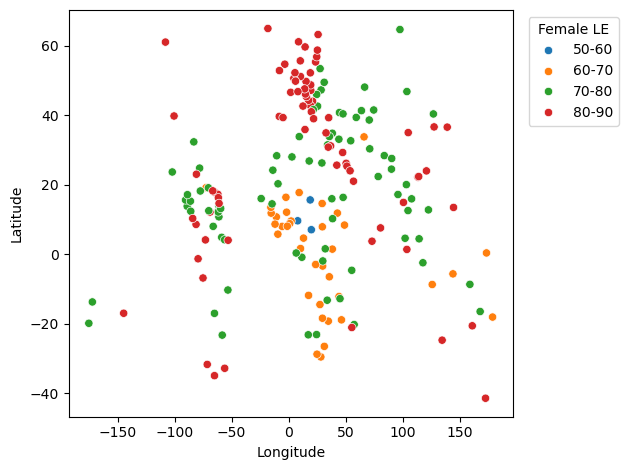

In [38]:
sns.scatterplot(
    data=merged_df,
    x='Longitude',
    y='Latitude',
    hue="life_expectancy_female"
)
# plt.title("Female vs Male Life Expectancy by Country")
plt.legend(title="Female LE", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

## Bulding the Model

In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(merged_df[['Latitude', 'Longitude']], merged_df[['life_expectancy_female']], test_size=0.2, random_state=0)

# Normalize the training and test data
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [34]:
# Arbitrarily choose a number of clusters
# Create instance of kmeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
# Fit the model to the normalized trainign data
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, random_state=0)

<Axes: xlabel='Longitude', ylabel='Latitude'>

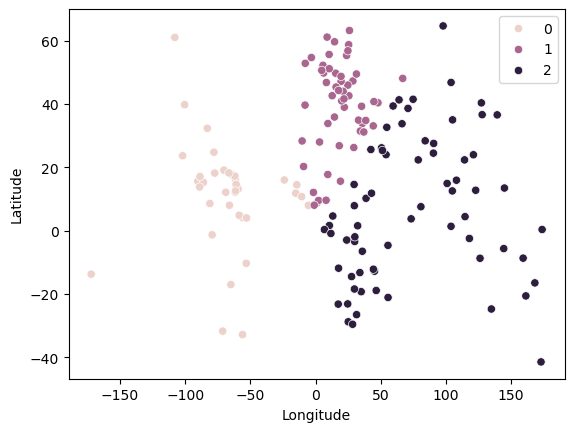

In [35]:
# Visualize the data fit
sns.scatterplot(data = X_train, x = 'Longitude', y = 'Latitude', hue = kmeans.labels_)

In [ ]:
# A silhouette score is a matric from evaluating the quality of clusters in data clutering, ranging from -1 to 1
# A higher score indicates that clusters are well-separated and data points are strongly associated with their assigned cluster, while a score near zero suggests overlapping clusters, and a negative score implies misclassification.

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')
# Score is satisfactory (greater than 0.5)

0.6269966700539663

### Finding the best value of k

In [37]:
# Try a different range of k value
K = range(2,8)
fits = []
score =  []

for k in K:
    # train and fit the model
    model = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X_train_norm)
    # append the model fit
    fits.append(model)
    # append the score of the mode
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

<Axes: xlabel='Longitude', ylabel='Latitude'>

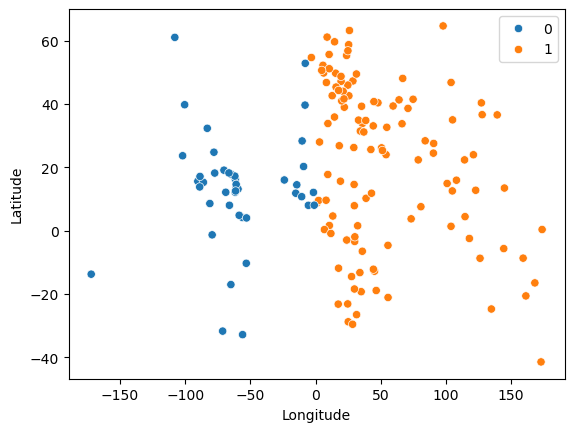

In [ ]:
# Look at when k=2
sns.scatterplot(data = X_train, x = 'Longitude', y = 'Latitude', hue = fits[0].labels_)

<Axes: xlabel='Longitude', ylabel='Latitude'>

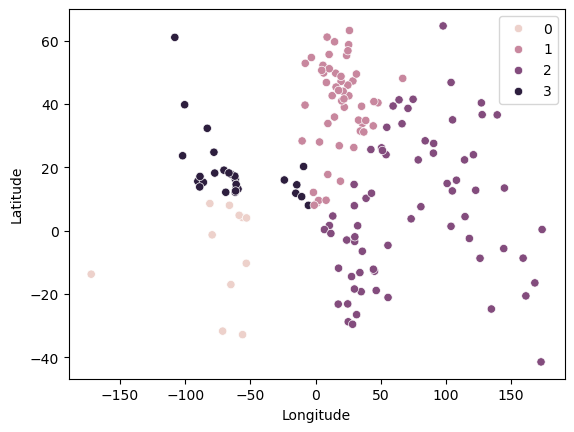

In [40]:
# Look at when k=4
sns.scatterplot(data = X_train, x = 'Longitude', y = 'Latitude', hue = fits[2].labels_)

<Axes: xlabel='Longitude', ylabel='Latitude'>

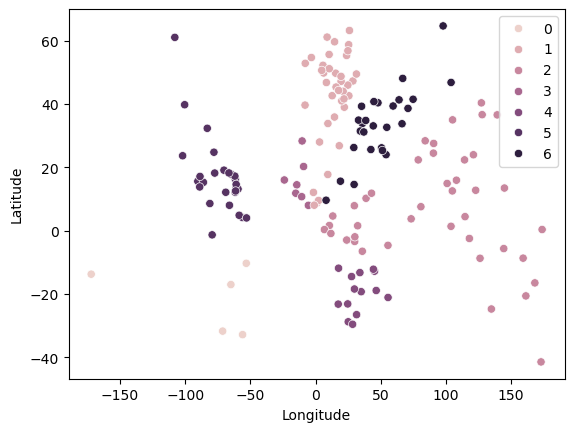

In [45]:
# Look at k=7
sns.scatterplot(data = X_train, x = 'Longitude', y = 'Latitude', hue = fits[5].labels_)

k=2 does not capture the nuances of the life expectancy across countries. While k=7 has too man clusters.

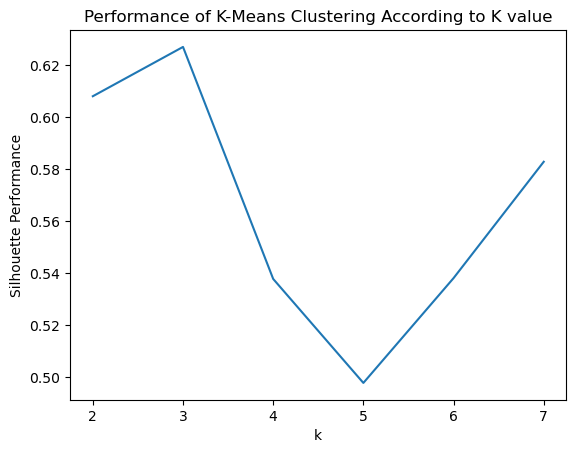

In [56]:
# Let's visualize k's by score performance
ax = sns.lineplot(x = K, y = score)
ax.set_title("Performance of K-Means Clustering According to K value")
ax.set(xlabel='k', ylabel='Silhouette Performance')

plt.show()

We can see improvements in clusters until k=3, then the model has diminishing returns and worse performance until k=5. Overfitting causes the model to then begin improving again.

### Interpretation and Insights

* Low life expectancy seemns to mostly cluster around Africa and parts of South Asia. Male and female life expectancy values tend to fall in the 50–60 year range.

These regions often face limited healthcare infrastructure, higher infectious disease burden, and economic constraints.

* Clusters for life expectancy between 65-75 years encompass many Latin American, Middle Eastern, and Southeast Asian countries.

These countries are in transitional stages of development, balancing improvements in healthcare access with ongoing challenges such as chronic disease and inequality.

* Countries with the clusters of highest life expectancy are developed regions, including Western Europe, North America, Australia, Japan, and other high-income economies.